(### WARNING ### - do not use 2021-01-18_trySaturated.ipynb! It uses an older SaturationStacker pre bugfixes. Use this notebook instead.)

In [1]:
# 2021-01-17 - try to run PY's new saturation stacker
#
# 2021-02-18 UPDATED with the corrected saturation stacker (there was a bug in the original).
# This new saturation stacker is in the github sims_maf (and was pasted here). When Datalab's
# version is updated to have this stacker, I will remove the corresponding cell in this notebook.
#
# THis is all pasted from a prototype notebook Peter Yoachim produced in response to queries.
#
# Updated with some syntax to find the dynamic range between the median saturation limit in the 
# short exposures and the coadded m5 depth in the long exposures. If there are no short exposures
# in the opsim, then the saturation limit is taken from the long exposures. If there are no long
# exposures then the m5 depth is taken from the short exposures. "Short" and "Long" are defined as 
# having total visit time less than or above timeCut = 20 seconds.

In [2]:
# import python pieces
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp



In [3]:
# top level directory for opsim databases
#
# on sciserver
# dbroot='/home/idies/workspace/lsst_cadence/FBS_1.5/'  

# on datalab
dbroot='/sims_maf/fbs_1.5/short_exp/'

In [4]:
# for making a new metricBundle
import copy

In [5]:
# import lsst-relevant stuff
import lsst.sims.maf.stackers as stackers

In [6]:
class SaturationStacker(stackers.BaseStacker):
    """Calculate the saturation limit of a point source. Assumes Guassian PSF.
    
    Parameters
    ----------
    pixscale : float, opt (0.2)
        Arcsec per pixel
    gain : float, opt (2.3)
        electrons per adu
    saturation_e : float, opt (150e3)
        The saturation level in electrons
    zeropoints : dict-like, opt (None)
        The zeropoints for the telescope. Keys should be str with filter names, values in mags.
        If None, will use Rubin-like zeropoints.
    km : dict-like, opt (None)
        Atmospheric extinction values.  Keys should be str with filter names. If None, will use Rubin-like zeropoints.
    """
    colsAdded = ['saturation_mag']

    def __init__(self, seeingCol='seeingFwhmEff', skybrightnessCol='skyBrightness',
                 exptimeCol='visitExposureTime', nexpCol='numExposures',
                 filterCol='filter', airmassCol='airmass',
                 saturation_e=150e3, zeropoints=None, km=None, pixscale=0.2, gain=1.0):
        self.units = ['mag']
        self.colsReq = [seeingCol, skybrightnessCol, exptimeCol, nexpCol, filterCol, airmassCol]
        self.seeingCol = seeingCol
        self.skybrightnessCol = skybrightnessCol
        self.exptimeCol = exptimeCol
        self.nexpCol = nexpCol
        self.filterCol = filterCol
        self.airmassCol = airmassCol
        self.saturation_adu = saturation_e/gain
        self.pixscale = 0.2
        names = ['u', 'g', 'r', 'i', 'z', 'y']
        types = [float]*6
        if zeropoints is None:
            # Note these zeropoints are calculating the number of *electrons* per second (thus gain=1)
            # https://github.com/lsst-pst/syseng_throughputs/blob/master/notebooks/Syseng%20Throughputs%20Repo%20Demo.ipynb
            self.zeropoints = np.array([27.03, 28.38, 28.15, 27.86, 27.46, 26.68]).view(list(zip(names, types)))
            self.saturation_adu = saturation_e 
        else:
            self.zeropoints = zeropoints

        if km is None:
            # Also from notebook above
            self.km = np.array([0.491, 0.213, 0.126, 0.096, 0.069, 0.170]).view(list(zip(names, types)))
        else:
            self.km = km

    def _run(self, simData, cols_present=False):
        for filtername in np.unique(simData[self.filterCol]):
            in_filt = np.where(simData[self.filterCol] == filtername)[0]
            # Calculate the length of the on-sky time per EXPOSURE
            exptime = simData[self.exptimeCol][in_filt] / simData[self.nexpCol][in_filt]
            # Calculate sky counts per pixel per second from skybrightness + zeropoint (e/1s)
            sky_counts = 10.**(0.4*(self.zeropoints[filtername] - simData[self.skybrightnessCol][in_filt])) * self.pixscale**2
            # Total sky counts in each exposure 
            sky_counts = sky_counts * exptime
            # The counts available to the source (at peak) in each exposure is the difference between saturation and sky
            remaining_counts_peak = (self.saturation_adu - sky_counts)
            # Now to figure out how many counts there would be total, if there are that many in the peak
            sigma = simData[self.seeingCol][in_filt]/2.354
            source_counts = remaining_counts_peak * 2.*np.pi*(sigma/self.pixscale)**2
            # source counts = counts per exposure (expTimeCol / nexp)
            # Translate to counts per second, to apply zeropoint 
            count_rate = source_counts / exptime
            simData['saturation_mag'][in_filt] = -2.5*np.log10(count_rate) + self.zeropoints[filtername]
            # Airmass correction
            simData['saturation_mag'][in_filt] -= self.km[filtername]*(simData[self.airmassCol][in_filt] - 1.)

        return simData

In [7]:
# set up for lsst
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles



In [8]:
# Connect to the database (on sciserver)
# dbroot='/home/idies/workspace/lsst_cadence/FBS_1.5/'  # now selected farther up
conn = db.OpsimDatabase(dbroot+'short_exp_5ns_5expt_v1.5_10yrs.db')
outDir = 'satur_test'
resultsDb = db.ResultsDb(outDir=outDir)
nside = 64 


In [9]:
# Variables
timeCut = 20.
sFilter = 'r'

# Define the metric bundle and the slicer
bundleList = []

stacker = SaturationStacker()

sqlLong = 'filter="%s" and visitExposureTime > %.1f' % (sFilter, timeCut)
metric = metrics.MedianMetric(col='saturation_mag')
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlLong,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                            stackerList=[stacker]))

# Now find the median depth
metricM5 = metrics.Coaddm5Metric('fiveSigmaDepth')
bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlLong,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats))

sqlShort = 'filter="%s" and visitExposureTime < %.1f' % (sFilter, timeCut)

bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlShort,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                            stackerList=[stacker]))

bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlShort,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats))



Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with constraint filter="r" and visitExposureTime > 20.0 for columns ['fieldRA', 'visitExposureTime', 'seeingFwhmEff', 'numExposures', 'fieldDec', 'fiveSigmaDepth', 'filter', 'skyBrightness', 'airmass']
Found 482646 visits
Running:  ['opsim_Median_saturation_mag_r_and_visitExposureTime_gt_20_0_HEAL', 'opsim_CoaddM5_r_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="r" and visitExposureTime < 20.0 for columns ['fieldRA', 'visitExposureTime', 'seeingFwhmEff', 'numExposures', 'fieldDec', 'fiveSigmaDepth', 'filter', 'skyBrightness', 'airmass']
Found 138694 visits
Running:  ['opsim_Median_saturation_mag_r_and_visitExposureTime_lt_20_0_HEAL', 'opsim_CoaddM5_r_and_visitExposureTime_lt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r" and 

/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 15.0569  dipole: lon: 146.964, lat: -51.5207, amp: 0.272145
  mono, lon, lat, amp
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 26.4606  dipole: lon: 119.909, lat: -70.9981, amp: 0.450809
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="r" and visitExposureTime < 20.0" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 13.1112  dipole: lon: 159.347, lat: -39.2386, amp: 0.266245
  mono, lon, lat, amp
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 24.8449  dipole: lon: 137.255, lat: -58.6051, amp: 0.282624
  mono, lon, lat, amp


Plotting complete.


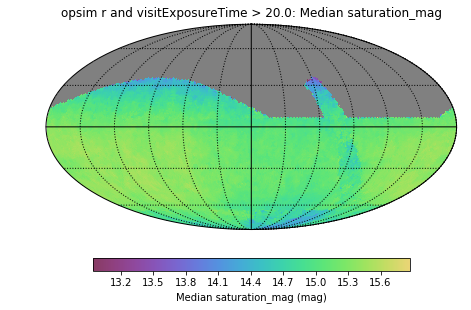

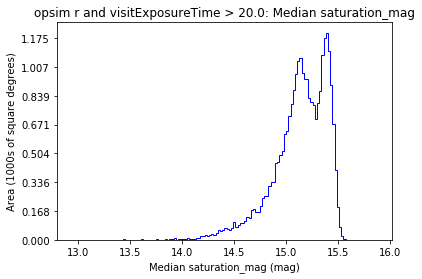

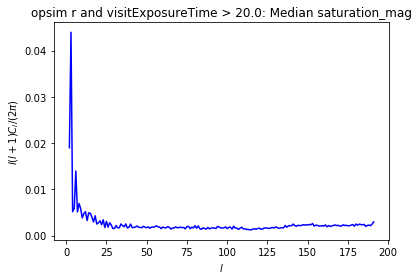

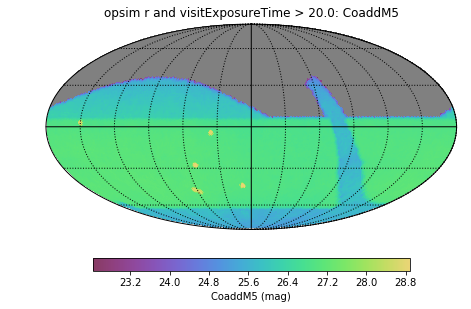

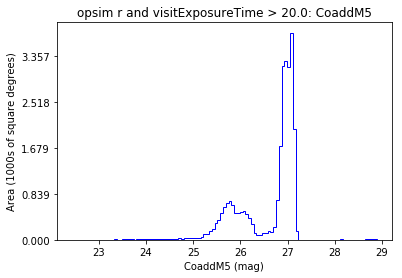

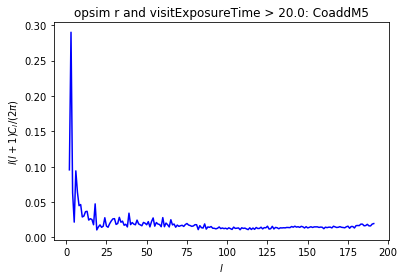

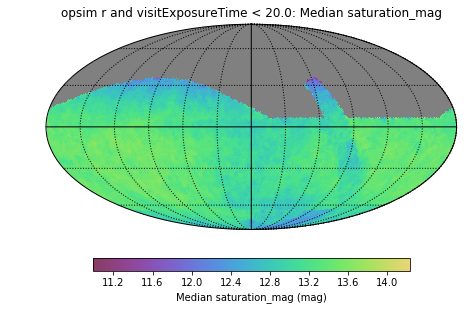

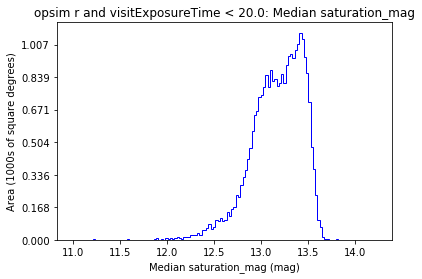

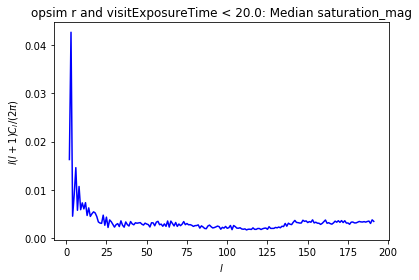

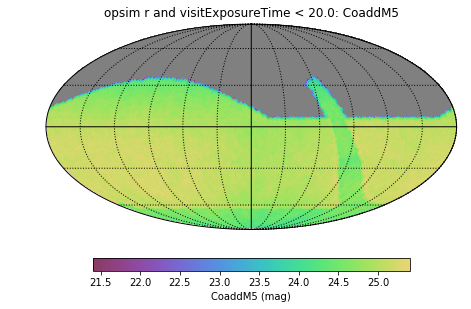

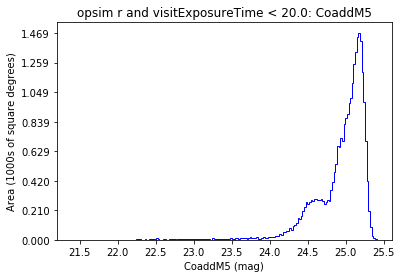

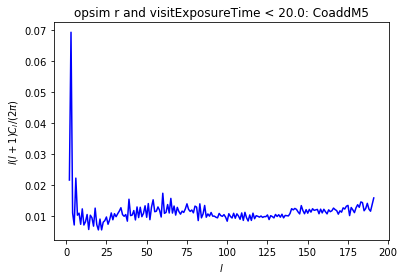

In [10]:
# actually run things
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [11]:
# Below, we will use the saturation limit and the m5 limiting depth from the 
# short or long exposures as appropriate. 
#
# which keys we use depends on whether there actually *were* "short" as 
# well as "long" exposures in the opsim. There's probably a sims_maf-ish way 
# to learn this, but for the moment we just determine which does not have 
# "None" as the metricValues. We first learn which keys correspond to the 
# pieces we want, then find out which are populated.

# These dictionaries are keyed by the search terms in the bundle names.
# For clarity let's just use one dictionary each for the saturation mag
# and for the m5 magnitude keys. Doing things this way should allow us 
# to make changes to the search string up above (e.g. by varying the 
# filter) and everything from here down should be unaffected.
keySats = {'lt':'DUMMY', 'gt':'DUMMY'}
keyMags = {'lt':'DUMMY', 'gt':'DUMMY'}

# Look for keys that have "lt" and "saturation_mag"
for sKey in bg.bundleDict.keys():
    for sSz in keySats.keys():
        if sKey.find(sSz) > -1:
            if sKey.find('saturation_mag') > -1:
                keySats[sSz] = sKey[:]
            if sKey.find('CoaddM5') > -1:
                keyMags[sSz] = sKey[:]

# Default bundles to use: short exp for saturation and long exp for m5 depth
keySatUse = keySats['lt'][:]
keyM5Use = keyMags['gt'][:]

# If the short-exposure bundle has no metricValues, switch to the long-exposure
if bg.bundleDict[keySatUse].metricValues is None:
    keySatUse = keySats['gt'][:]

# if the long-exposure bundle has no metricValues, switch to the short-exposure
if bg.bundleDict[keyM5Use].metricValues is None:
    keyM5Use = keyMags['lt'][:]
                
print("INFO - saturation will use %s" % (keySatUse))
print("INFO - m5 coadd   will use %s" % (keyM5Use))


INFO - saturation will use opsim_Median_saturation_mag_r_and_visitExposureTime_lt_20_0_HEAL
INFO - m5 coadd   will use opsim_CoaddM5_r_and_visitExposureTime_gt_20_0_HEAL


In [12]:
# find the difference: deep coadd m5 minus median saturation level
valuesDiffs = bg.bundleDict[keyM5Use].metricValues - bg.bundleDict[keySatUse].metricValues

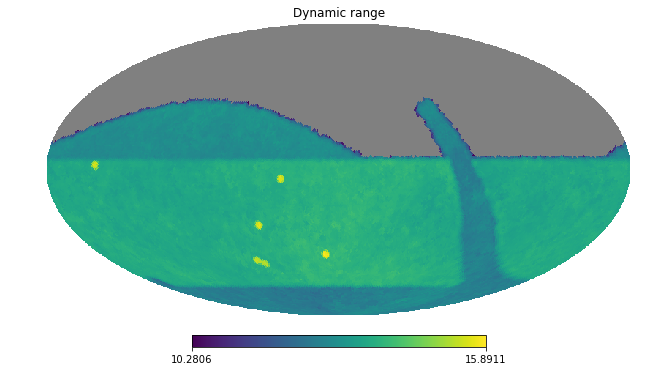

In [13]:
# HERE IS WHERE WE SHOW THE DYNAMIC RANGE. We ought to determine how we're going 
# to encode this into a figure of merit. Since we have our metric now as Healpix
# locations, this should (!) be relatively straightforward.
dum = hp.mollview(valuesDiffs, title='Dynamic range')

In [ ]:
!pwd


	      Welcome to the NOAO Data Lab Notebook Server

   The JupyterHub server provides limited shell access to authenticated
users to enable bulk transfer of files/data for use in notebooks, or to 
update example notebooks to the latest version using shell commands. It
contains at least the following three directories:

    notebooks/		User notebook directory
    notebooks-latest/	Latest Data Lab notebooks (read-only access)
    vospace/		A link to the user's VOSpace directory (experimental)

Please consult notebooks-latest/_README.txt for brief information about the
default notebooks provided with your account.  To get the latest copies of
the default notebooks copied to your 'notebooks' directory, type

	% getlatest	# this is defined in your .bashrc file

Existing dir will be backed-up to 'notebooks_<timestamp>'.

The limited shell provides the following commands which may be used to
import external data or files:

    scp			Secure copy from remote host 
    ssh			Remote login progr